# The Zimm-Bragg model

In [1]:
import numpy as np
import math

## The theoretical value

The theoretical value of the helicity has been derived in the notes, and can be written as a function of the transfer matrix eigenvalues $\lambda_1$ and $\lambda_2$ as

$$
\theta_N = \frac{\lambda_1 - 1}{\lambda_1 - \lambda_2} \frac{1 + \left( \frac{\lambda_2}{\lambda_1} \right)^{N+1} - \frac{2}{N}\frac{\lambda_2}{\lambda_1 - \lambda_2} \left[ 1 - \left( \frac{\lambda_2}{\lambda_1} \right)^{N} \right]}{1 + \frac{\lambda_1 - 1}{1 - \lambda_2}\left( \frac{\lambda_2}{\lambda_1} \right)^{N+1}}
$$

The following function computes and returns it for the given values of the chain length $N$ and the Zimm-Bragg parameters $s$ and $\sigma$. Note that extreme values of the parameters will give raise to numerical issues (and possibly errors). Those can be avoid by taking care of edge cases, and/or by explicitly using the expressions for $\lambda_1$ and $\lambda_2$ to simplify the relation above.

In [2]:
def theoretical_zimm_bragg(N, s, sigma):
    l_1 = 1 + (s - 1) / 2 + math.sqrt(((s - 1) / 2)**2 + sigma * s)
    l_2 = 1 + (s - 1) / 2 - math.sqrt(((s - 1) / 2)**2 + sigma * s)
    
    r = l_2 / l_1
    
    theta = (l_1 - 1) / (l_1 - l_2)
    theta *= 1 + r**(N + 1) - 2 / N * l_2 / (l_1 - l_2) * (1 - r**N)
    theta /= 1 + (l_1 - 1) / (1 - l_2) * r**(N + 1)
    
    return theta

## The Monte Carlo Metropolis method

### Introduction

The model prescribes (or makes it possible to compute) the statistical weight of any chain configuration. We can leverage this knowledge to sample the available configurations in equilibrium by using a specific Monte Carlo (MC) technique known as the Metropolis method.

The discussion below is taken from the Frenkel and Smit book.

Consider the whole phase space of the system. By definition, each state $i$ is visited with a probability given by its statistical weight, $W_i$. We now wish to find a way of sampling the phase space so that the equilibrium distribution, given by the weights $\lbrace W \rbrace$, is retained. In order to do so we define the transition probability matrix $A_{i \to j}$ to go from state $i$ to state $j$, with the obvious constraint that its elements have to be such that the equilibrium distribution is conserved. A sufficient condition to fulfill such a constraint is that, for each pair $i, j$,

$$
W_i A_{i \to j} = W_j A_{j \to i},
$$

which is also known as "detailed balance". The transition matrix can be decoupled as a product of two matrices,

$$
A_{i \to j} = \alpha(i \to j) P(i \to j),
$$

where $\alpha(i \to j)$ is the probability of proposing the $i\to j$ change, and $P(i \to j)$ is the probability to accept the change, also known as "acceptance probability". In the simple scheme we will consider the matrix $\alpha$ to be symmetric, so that the first equation of this section can be written as

$$
W_i P_{i \to j} = W_j P_{j \to i},
$$

and therefore

$$
\frac{P_{i \to j}}{P_{j \to i}} = \frac{W_i}{W_j}.
$$

Any choice of the elements $P_{i \to j}$ that satisfy the above condition will sample the phase space in equilibrium (given enough simulation time). The choice made by Metropolis *et al*, which is by far the most common, is

$$
P(i \to j) = \min \left\lbrace 1, \frac{W_j}{W_i} \right\rbrace.
$$

In a microscopic system (*i.e.* a system where it is possible to specify a Hamiltonian), the statistical weight takes a simple (and famous) form:

$$
W_i = e^{-\beta E_i},
$$

where $E_i$ is the energy of configuration $i$, so that the acceptance probability is just

$$
P(i \to j) = \min \left\lbrace 1, e^{-\beta \Delta E_{ij}} \right\rbrace,
$$

where $\Delta E = E_j - E_i$ is the energy difference between the two configurations.

### Observables

In the statistical mechanics approach, a quantity of interest $O$ can be evaluated by taking an average over the ensemble of the equilibrium configurations:

$$
\langle O \rangle = \frac{\sum_i O_i W_i}{\sum_i W_i},
$$

where $O_i$ is the value of $O$ for the configuration $i$. Since with the MC method sketched above we sample equilibrium configurations, we can approximate the above relation as

$$
\langle O \rangle \approx \frac{1}{N} \sum_t O_t,
$$

where $t$ runs over the simulation iterations. Note that in most MC schemes (like the one considered here), configurations that are "close in time" (*i.e.* are separated by few iterations) are correlated. As a result, it is often sufficient to update the averages every $N_t$ iterations rather than after each iteration.

**Nota Bene:** in real systems it is not possible to sample the *whole* phase space, but we need to simulate for long enough that enough representative states are sampled. A necessary, but by no means sufficient, condition to judge the quality of the sampling is that the average value $\langle O \rangle$ plotted against the simulation time converges to some value, perhaps with small fluctuations.

### Implementation in the Zimm-Bragg model

Here we implement the Monte Carlo Metropolis algorithm in this way:

1. We start with a configuration $i$, which has a statistical weight $W_i$
2. We propose a new configuration $j$, which has a statistical weight $W_j$, which is identical to $i$ but for the conformation of a single residue, which is randomly chosen and flipped (`c` $\to$ `h` or `h` $\to$ `c`).
3. We accept the change (*i.e.* the chain acquires the new configuration $j$) with probability
$$
P(i \to j) = \min \left\lbrace 1, \frac{W_j}{W_i} \right\rbrace
$$
4. We go back to step 1, regardless of whether we accepted or rejected the flipping.

By iterating this procedure many times, we sample the phase space of the configurations. In the code below, we first run a certain amount of "Monte Carlo steps", where each MC step is defined as $N$ iterations, where $N$ is the length of the chain, to "equilibrate" the system, *i.e.* to obtain a typical equilibrium configuration. After this equilibration we begin to keep track of the helicity, so that at the end of the simulation we can return its value, averaged over the ensemble of generated configurations.

We now have to discuss how to evaluate the statistical weight associated to a configuration. First of all, note that we don't need the single statistical weights of the $i$ and $j$ configurations, but only their ratio. Moreover, in the Zimm-Bragg model the total weight of the chain can be decomposed in the product of the weights associated to each residue, *viz.*

$$
W_i = \Pi_{\gamma = 1}^N W_i^\gamma,
$$

where $W_i^\gamma$ is the statistical weight of residue $\gamma$ and depends on its state (`h` or `c`) and possibly on its interaction with its neighbours. These are all the possibilities:

1. $\gamma$ is in the coil state: $W_i^\gamma = 1$
2. $\gamma$ is in the helical state, and the residue before is also `h`: $W_i^\gamma = s$
3. $\gamma$ is in the helical state, but the residue before is a `c`: $W_i^\gamma = s\sigma$

Since each weight is the product of the single weights associated to each residue, all the weights relative to the non-flipping residues cancel out. Therefore, if the randomly chosen residue is $\gamma$ we have that

$$
P(i \to j) = \min \left\lbrace 1, \frac{W_j^\gamma}{W_i^\gamma} \right\rbrace.
$$

When computing the weight ratio, there are two components, one due to the propagation term, and one due to the cooperative (initiation) term. The former is easy to compute, as it is $s$ if the $\gamma$ flips to `h`, and $1/s$ if it flips to `c`. The latter is slightly more complicated, as we have to take into account several possibilities:

* if $\gamma$ is not the first nor the last residue of the chain, there are two cases that result in a cooperative contribution, depending on the state of its two neighbours:
  1. if the initial state of the triplet is `chc` or `hch`, flipping the central residue decreases the number of helices by one, and therefore we get back the cooperative price and divide the weight ratio by $\sigma$
  2. if the initial state of the triplet is `hhh` or `ccc`, flipping the central residue increases the number of helices by one, and therefore we pay the cooperative price and multiply the weight ratio by $\sigma$
* If $\gamma$ is the first residue and the one that follows it is in the `c` state:
  1. if the new state is `h` we are creating a new helix, so we multiply the weight ratio by $\sigma$
  2. if the new state is `c` we are removing a helix, so we divide the weight ratio by $\sigma$
* Similarly, if $\gamma$ is the last residue and the one that precedes it is in the `c` state:
  1. if the new state is `h` we are creating a new helix, so we multiply the weight ratio by $\sigma$
  2. if the new state is `c` we are removing a helix, so we divide the weight ratio by $\sigma$
  
The code below checks for these alternatives in the (hopefully) clearest possible way.

In [3]:
def metropolis_zimm_bragg(N, s, sigma):
    # initialize the chain randomly (1 for helix, 0 for coil)
    chain = np.random.choice([0, 1], size=N)

    # return the ratio between the statistical weights due to the flipping of the index-th residue
    def change_probability(chain, index):
        current_state = chain[index]
        new_state = 1 - current_state

        # calculate the ratio due to the propagation term
        if new_state == 0:
            prob = 1 / s
        else:
            prob = s
        
        # and that relative to the cooperative (initiation) term
        if index == 0: # first residue
            if chain[index + 1] == 0:
                if new_state == 1:
                    prob *= sigma
                else:
                    prob /= sigma
        elif index == N - 1: # last residue
            if chain[index - 1] == 0:
                if new_state == 1:
                    prob *= sigma
                else:
                    prob /= sigma
        # here we take into account two cases: either a helix is split in two or a helix is created
        # in both cases we pay the cooperative price
        elif new_state != chain[index - 1] and new_state != chain[index + 1]:
            prob *= sigma
        # here we take into account the case where the flipped residue either removes an helix, or join two helices
        elif new_state == chain[index - 1] and chain[index - 1] == chain[index + 1]:
            prob /= sigma
        
        return prob
  
    # Monte Carlo simulation
    fraction_helical = 0
    count = 0
    for i in range(steps):
        for _ in range(N):
            # randomly pick a residue to flip
            index = np.random.randint(N)

            # calculate the probability change
            prob = change_probability(chain, index)

            # accept or reject the change
            if prob > 1 or np.random.rand() < prob:
                chain[index] = 1 - chain[index]
            
        # skip the first steps to let the chain equilibrate
        if i > steps // 10:
            fraction_helical += np.mean(chain)
            count += 1

    return fraction_helical / count

## A simple test

Here we test the two functions on a chain made of $20$ residues, for a specific pair of $\sigma$ and $s$ values. Feel free to play around with these values and see if what happens aligns with your intuition.

In [17]:
N = 100
sigma = 1e-7
s = 0.5
steps = 10000  # number of Monte Carlo steps

theta_th = theoretical_zimm_bragg(N, s, sigma)
theta_MC = metropolis_zimm_bragg(N, s, sigma)
print(f"Theoretical fraction of helical content: {theta_th}")
print(f"Numerical fraction of helical content: {theta_MC}")

Theoretical fraction of helical content: 1.9599988494582937e-07
Numerical fraction of helical content: 0.0


## The melting curve

Here I show a slightly more complicated example where we use the two functions above to evaluate the fraction of helicity of a chain as a function of temperature. Note that to make it more realistic we consider $f_h$ to have an enthalpic contribution, $\Delta H$, and an entropic contribution, $\Delta S$. If you recall, in the two-state (uncooperative) model, the melting temperature is just

$$
T_M = \frac{\Delta H}{\Delta S}.
$$

Here I chose to set $\Delta S = \Delta H$ so that $T_M = 1$ if $\sigma = 1$. I then set $\Delta H = -1$ and $\sigma = 10^{-3}$. Since it has an enthalpic component, $s$ is temperature-dependent, and therefore should be recomputed every time $T$ varies. This is done within the loop.

Note that I'm using arbitrary units of measurements chosen so that the most important parameters are of order 1.

Evaluating temperature 0.2
Evaluating temperature 0.4
Evaluating temperature 0.6
Evaluating temperature 0.8
Evaluating temperature 1.0
Evaluating temperature 1.2


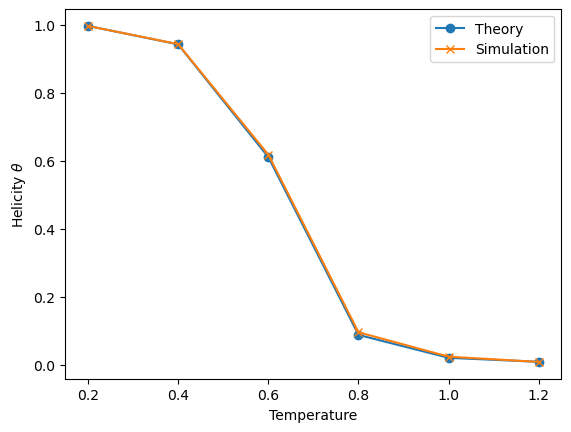

In [24]:
import matplotlib.pyplot as plt

theta_th = []
theta_MC = []

N = 10
sigma = 1e-3
s_delta_H = -1
s_delta_S = -1
steps = 50000

Ts = (0.2, 0.4, 0.6, 0.8, 1.0, 1.2)

for temperature in Ts:
    print("Evaluating temperature", temperature)
    beta_f_h = (s_delta_H - temperature * s_delta_S) / temperature
    s = math.exp(-beta_f_h)
    theta_th.append(theoretical_zimm_bragg(N, s, sigma))
    theta_MC.append(metropolis_zimm_bragg(N, s, sigma))

plt.plot(Ts, theta_th, 'o-', label="Theory")
plt.plot(Ts, theta_MC, 'x-', label="Simulation")
plt.xlabel("Temperature")
plt.ylabel(r"Helicity $\theta$") # note the r before the ", which makes it possible to use latex notation
plt.legend()
plt.show() # not strictly required in a notebook